# Transpilation to Linear Optics via ZX Dual-Rail Encoding

Start with a simple qubit quantum circuit.

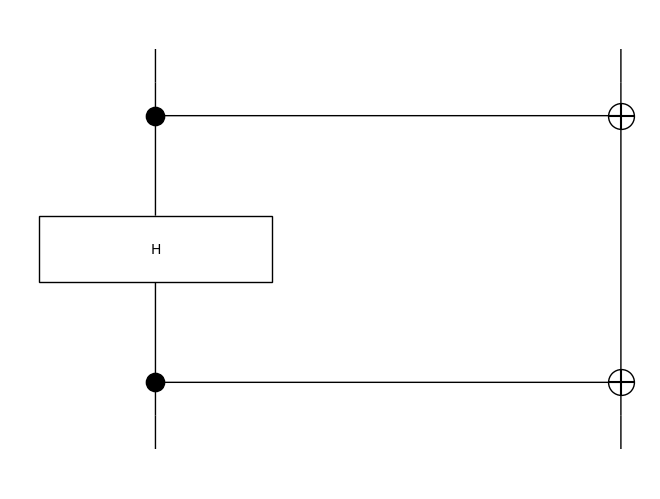

In [1]:
from discopy.quantum import CX, H, Id

circuit = CX >> H @ Id(1) >> CX
circuit.draw()

Convert to ZX using `circuit2zx`

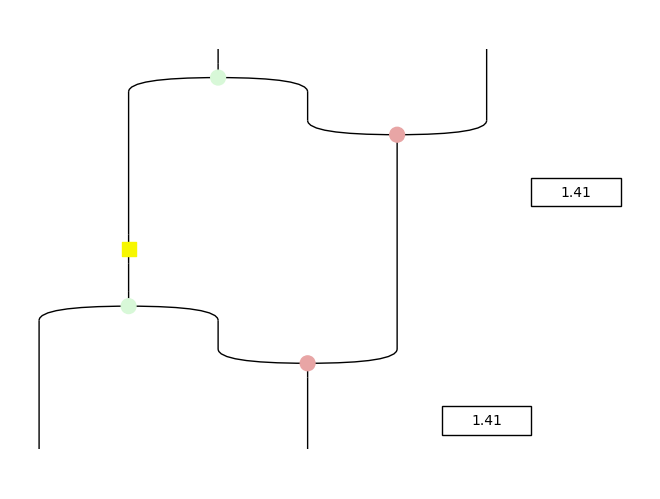

In [2]:
from discopy.quantum.zx import circuit2zx

diagram = circuit2zx(circuit)
diagram.draw()

Convert to QPath using `zx_to_path`

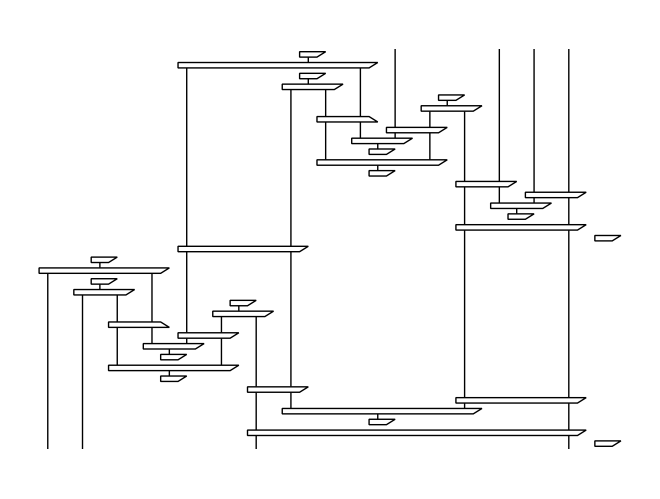

In [3]:
from optyx.zx import zx_to_path

circ = zx_to_path(diagram)
circ.draw(draw_box_labels=False, draw_type_labels=False)

In the dual rail encoding, each qubit gets mapped to 2 linear optical modes.
Specifically $\ket{0}$ and $\ket{1}$ get mapped to $\ket{1, 0}$ and $\ket{0, 1}$ respectively.

Here are all the $n$ qubit dual rail states.

In [4]:
def dual_rail_states(n_qubits):
    strings = []
    def genbin(n, bs=[]):
        if len(bs) == 2*n:
            strings.append(bs)
        else:
            genbin(n, bs + [1, 0])
            genbin(n, bs + [0, 1])
    genbin(n_qubits)
    return strings

dual_rail_states(3)

[[1, 0, 1, 0, 1, 0],
 [1, 0, 1, 0, 0, 1],
 [1, 0, 0, 1, 1, 0],
 [1, 0, 0, 1, 0, 1],
 [0, 1, 1, 0, 1, 0],
 [0, 1, 1, 0, 0, 1],
 [0, 1, 0, 1, 1, 0],
 [0, 1, 0, 1, 0, 1]]

Then we calculate amplitudes of input output pair by sampling the permenant of the unitary associated with the QPath diagram (For details see https://arxiv.org/abs/1011.3245).

In [5]:
def evaluate(circ, x, y):
    """ Evaluate the probability of <y|U_h|x> """
    from optyx import Id, Create, Select
    inp = Id().tensor(*[Create(i) for i in x])
    out = Id().tensor(*[Select(i) for i in y])

    return ((inp >> circ >> out).eval().array.flatten().item())

In [6]:
import numpy as np

states = dual_rail_states(len(circuit.cod))
array = np.array([[evaluate(circ, x, y) for x in states] for y in states])
np.round(array, decimals=3)

array([[ 0.707-0.j, -0.   +0.j,  0.   +0.j,  0.707+0.j],
       [-0.   +0.j,  0.707+0.j,  0.707+0.j,  0.   -0.j],
       [-0.   -0.j,  0.707-0.j, -0.707+0.j, -0.   -0.j],
       [ 0.707-0.j, -0.   -0.j, -0.   -0.j, -0.707+0.j]])

which is equal to the direct simulation of the original quantum circuit.

In [7]:
np.round(circuit.eval().array.reshape(4, 4), decimals=3)

array([[ 0.707+0.j,  0.   +0.j,  0.   +0.j,  0.707+0.j],
       [ 0.   +0.j,  0.707+0.j,  0.707+0.j,  0.   +0.j],
       [ 0.   +0.j,  0.707+0.j, -0.707+0.j,  0.   +0.j],
       [ 0.707+0.j,  0.   +0.j,  0.   +0.j, -0.707+0.j]])